# Movies view estimations in Python

The goal of this task is to implement a model in python to estimate the number of views a movie has.


**Disclaimer**: The goal of this task (at least for me), was not really in the implementation but for you to see how I would work to resolve this kind of problems. This is by no means a finished and penultimate solution but the fruit of my work.

I hope that this will satisfy you nonetheless.

## 1- Data Loading

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
INPUT_FILE = "../data/top-250-movie-ratings.csv"
OUTPUT_FILE = "../output/moviesViewEstimations.csv"

RANDOM_STATE = 100

In [3]:
data = pd.read_csv(INPUT_FILE)

In [4]:
data.head()

,Unnamed: 0,Title,Year,Rating,Rating Count
0,tt0111161,The Shawshank Redemption,1994,9.2,"2,089,382"
1,tt0068646,The Godfather,1972,9.2,"1,433,884"
2,tt0071562,The Godfather: Part II,1974,9.0,"995,997"
3,tt0468569,The Dark Knight,2008,9.0,"2,055,819"
4,tt0050083,12 Angry Men,1957,8.9,"591,688"


In [5]:
#Lets take a look at the types of the columns in the dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    250 non-null    object 
 1   Title         250 non-null    object 
 2   Year          250 non-null    int64  
 3   Rating        250 non-null    float64
 4   Rating Count  250 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 9.9+ KB


In [6]:
#We can see that Raiting count is a string, we will to convert it as a int for the rest of the exercise.

if data['Rating Count'].dtype == 'object':
    data['Rating Count'] = data['Rating Count'].str.replace('[^\d.]', '').astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    250 non-null    object 
 1   Title         250 non-null    object 
 2   Year          250 non-null    int64  
 3   Rating        250 non-null    float64
 4   Rating Count  250 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 9.9+ KB


In [7]:
# removing the col Unnamed: 0 as it is not needed
data.drop(columns=['Unnamed: 0'], axis = 1)
data.head()

,Unnamed: 0,Title,Year,Rating,Rating Count
0,tt0111161,The Shawshank Redemption,1994,9.2,2089382
1,tt0068646,The Godfather,1972,9.2,1433884
2,tt0071562,The Godfather: Part II,1974,9.0,995997
3,tt0468569,The Dark Knight,2008,9.0,2055819
4,tt0050083,12 Angry Men,1957,8.9,591688


# 2 - Adding the limited view data

In [8]:
film_names = ["Forrest Gump", "The Usual Suspects", "Rear Window", "North by Northwest", "The Secret in Their Eyes", "Spotlight"]
film_views = [10000000, 7500000, 6000000, 4000000, 3000000, 1000000]

for i in range(len(film_names)):
    id = data['Title'] == film_names[i]
    data.loc[id,"views"] = film_views[i]

In [9]:
data[data['Title'].isin(film_names)]

,Unnamed: 0,Title,Year,Rating,Rating Count,views
11,tt0109830,Forrest Gump,1994,8.7,1602217,10000000.0
28,tt0114814,The Usual Suspects,1995,8.5,903320,7500000.0
45,tt0047396,Rear Window,1954,8.5,397045,6000000.0
76,tt0053125,North by Northwest,1959,8.3,270627,4000000.0
138,tt1305806,The Secret in Their Eyes,2009,8.2,172373,3000000.0
212,tt1895587,Spotlight,2015,8.1,362975,1000000.0


In [10]:
data['views'].isnull().sum()

244

In [11]:
print("Percentage of annotated data: {:.1f} %".format((len(data) - data['views'].isnull().sum())/len(data)*100))

Percentage of annotated data: 2.4 %


## 3 - Discussion

The goal of this exercise it to find some kind of basic model to estimate the number of view of the films based on a subset of the views data.

Based on the data that we have, only 2.4% of the dataset is annotated. Also, as an analyst, one could expect that other factors not depicted outside of this table could heavily influence the number of views.


We will thus make the following assumptions:

- The data that we have in this document will be considered as hard to obtain. Hence, we will not try to augmentate the data by crossing it with an external database such as [imdb](https://www.imdb.com/interfaces/) or the [MovieLens](https://www.kaggle.com/datasets/danielgrijalvas/movies) one.

- Given the small amount of annotated data, we will not try to use any NLP techniques on the names of the films to extract some metadata out of it. Indeed, some names like 'spotlight' can be considered in many movies genre (ex: "spotlight, a star is born" or "spotlight, the political life of J.F Kennedy"). Furthermore, even though we are able to extract some meaningful metdata out of those names, with only 6 samples, we are quite assured that this procedure will only add some noise to our model.

Hence, for our approach, we will not try to use a complex model here but rather a simple one. The main objective would be to find a technique that will not overfit on our small dataset.


## 4 - Data analysis:

In this section, our aim is to take a look at the distribution of the data as a whole as well as the distribution of our annotated data.
The objective of this step is to see if the annotated data that we have has a similar distribution as the rest of the dataset.

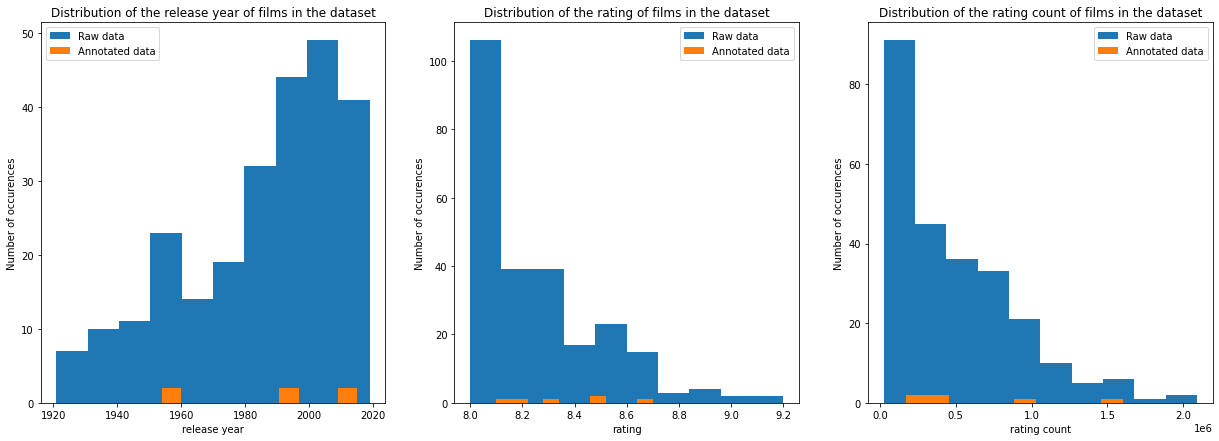

In [12]:
indexes = [
    ('Year', 'release year'),
    ('Rating', 'rating'),
    ('Rating Count', 'rating count')
]

fig, axes = plt.subplots(1, len(indexes), figsize = (7*len(indexes), 7))

for (feature_name, title_name), ax in zip(indexes, axes):
    
    ax.hist(data[feature_name], label = "Raw data")
    ax.hist(data[data['Title'].isin(film_names)][feature_name], label = "Annotated data")
    ax.set_xlabel(title_name)
    ax.set_ylabel("Number of occurences")

    ax.set_title("Distribution of the {} of films in the dataset".format(title_name))
    ax.legend()

plt.show()

From this short study, we can see that our data is not represneting only a subset of our dataset.

One thing to note nonetheless is the fact that the rating of our dataset is absolutely not even and restrained to a really short winow between 8/10 and 9.2/10 (which is a typical problem of many review systems).

## 5 - Processing

### A - Linear regression

The most simple model there is would be a linear regression. It will allow us to generalize the different results and to give an understandable guess.

In [13]:
# choose the input and outputs of the model
input_features = ['Year', 'Rating', 'Rating Count']
output_feature = ['views']

X = data[data['Title'].isin(film_names)][input_features]

y = data[data['Title'].isin(film_names)][output_feature]

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

# Train the model
reg = LinearRegression().fit(X_train, y_train)

print("Regression score", reg.score(X_test,y_test))
print("Regression coefficients", reg.coef_)


Regression score 0.8968682458178701
Regression coefficients [[2.06269142e+03 8.28438753e+06 2.79577236e+00]]


This is a pretty high regression score. Our model must be quite amazing right ?

Well, maybe not, lets use cross validation to have some indications about the variablity of our predictions.

In [15]:
lm = LinearRegression()

# We are here using our whole dataset to train the model, the goal is 
# just to see if the variance in the prediction is significant

#Given that we have only 6 films, we can make 3 splits  of 2 film each.
# The model will be trained on 4 films and tested on 2 films.

# create a KFold object with 5 splits 
folds = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
scores = cross_val_score(lm, X, y, scoring ='r2', cv=folds)

Linear regression scores :  [-0.81162326 -8.93798441  0.89686825]


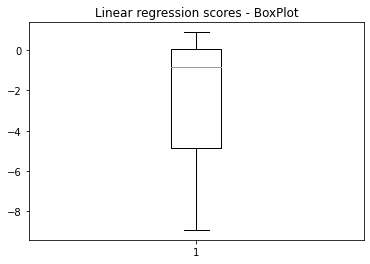

In [16]:
print("Linear regression scores : ", scores)
fig1, ax1 = plt.subplots()
ax1.set_title('Linear regression scores - BoxPlot')
ax1.boxplot(scores)
plt.show()

Given that the optimal score of the r2 metric is one, we can see that the model is actually performing quite badly here, with even a negative score. We might be overfitting our data.

However, is the model really to blame entirely there ?

In this case, a negative r2 score means that the mean of the y in the validation set are actually a better predictor of the values of y than our model. But in our case, we have onlyy two values in the validation set. Hence, it would suffice that 'The Secret in Their Eyes' with 3000000 views and 'Spotlight' with 1000000 views (the 2 films witht the least amount) would probably be better than our model since it never saw values that low.


In [17]:
#Visualization function(s)

def visualize_results(data: pd.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize = (7*2, 7))
    ax1 = axes[0]
    ax2 = axes[1]

    views_ground_truth, ratings_ground_truth, indices_ground_truth = [], [], []

    for i, (view, rating) in enumerate(zip(data['views'], data['Rating'])):
        if ~np.isnan(view):
            views_ground_truth.append(view)
            ratings_ground_truth.append(rating)
            indices_ground_truth.append(i)



    ax1.scatter([x for x in range(len(data))], data['predicted_views'], label = "Predicted views")
    ax1.scatter(indices_ground_truth, views_ground_truth, label = "Ground truth")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Views")
    ax1.set_title("Predicted views vs ground truth")
    ax1.legend()

    ax2.scatter([x for x in range(len(data))], data['Rating'], label = "Rating")
    ax2.scatter(indices_ground_truth, ratings_ground_truth, label = "Rating of the annotated data")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Rating")
    ax1.set_title("Rating vs annotated ratings")
    ax2.legend()

    plt.show()

In order to see if our model would still be somehow of some reasonnable quality, we will process our dataset with this model and visualize the results.
The objective here is to see if, despite being simplistic, our implementation will not provide aberrantly high or low values.

In [18]:
linear_model = LinearRegression().fit(X, y)
data["predicted_views"] = linear_model.predict(data[input_features])

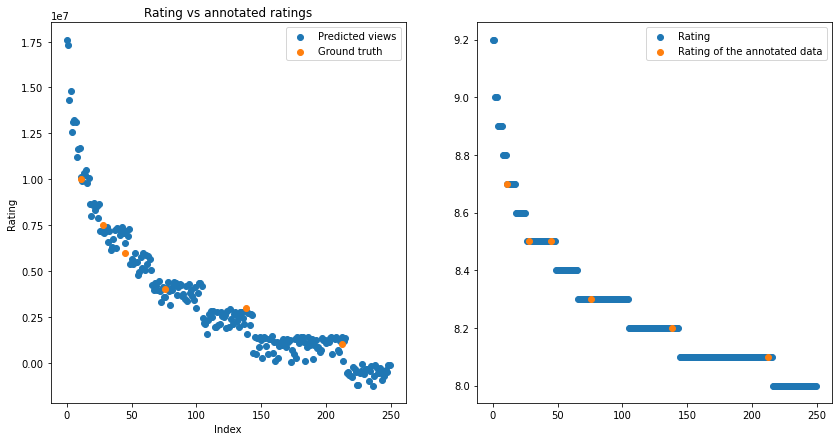

In [19]:
visualize_results(data)

In [20]:
#Check the case where we have a negative prediction count
sum(data['predicted_views'] < 0)

34

Sadly, we can see that our model does not map the reality as it is displaying some negative values for the views.

This can of course not be right and this seems to be highly correlated by the distribution of the grades.

In fact, in the figure above, we can see that the stratification of the views is quite remarkably  similar to the ones of the grades.
The issue is that we do not have any annotated data with the lowest grade. Hence, in this case, the linear regression just assumes the same step size jump between each specific grade.

This is not a good assumption as if we decide to extend this dataset with much higher or much lower grade, the model will not be able to predict the views realistically speaking.

____

Thus, we will try a rule based approach instead of a linear regression. The objective here is to see if learned rules, despite being simplistic, will not provide aberrantly high or low values.

## B - Decision Tree Regressor

In [21]:
regr = DecisionTreeRegressor(max_depth = 3, random_state = RANDOM_STATE)

regr.fit(X_train, y_train)

print("Score regr_1: {:.2f}".format(regr.score(X_test, y_test)))

Score regr_1: -0.20


We can see that once we reach a depth of That might not seem very good at first but lets try to see with our crossvalidation test. 

Linear regression scores :  [-0.81162326 -8.93798441  0.89686825]


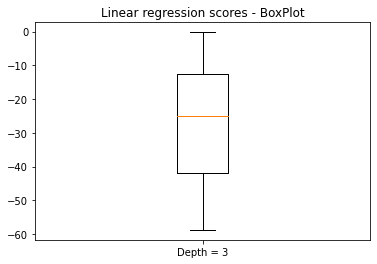

In [22]:
# create a KFold object with 5 splits 
scores_regr = cross_val_score(regr, X, y, scoring ='r2', cv=folds)
print("Linear regression scores : ", scores)
fig1, ax1 = plt.subplots()
ax1.set_title('Linear regression scores - BoxPlot')
ax1.boxplot(scores_regr, labels = ["Depth = 3"])
plt.show()

This might look even worse than the previous model, but lets nonetheless see how it performs intuitively.

In [23]:
regr_model = regr.fit(X, y)
data["predicted_views"] = regr_model.predict(data[input_features])

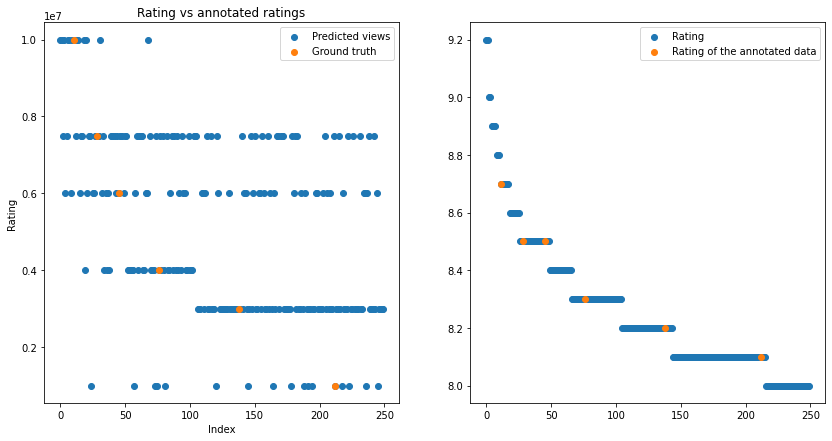

In [24]:
visualize_results(data)

With this, we can see the main difference between the linear regression and the decision tree. The decision tree keeps the values into boundaries and the linear regression doesn't.

Both behavior can be desired but in the case where both "tails" of our destribution of data are not properly mapped by the real values, using a rule based model could be preferable.

## C - Why not mix it up?

So far, we tried two models: a linear regression and a decision tree regressor. Both models being fairly simple.
In this step, I will not try to find a new model for our model but we will list the pro and cons of each one of them:

**Linear Regression**

Pros:
    
    - Great generalization

Cons:

    - Tends to lead to aberrant values for extreme inputs due to the lack of data

**Decision Tree Regressor**

Pros:

    - Rule-based approach, keep the data within boundaries of what is known -> Great for a first iteration as we do not get aberrant values.

Cons:

    - Not great generalization and uniform result

An other solution in our research for a representation would actually be to just use a part of the results of both models. This approach might not be a regorous one but it might be able to provide a smooth distribution of the results while removing the issue that we had with the linear regression.

In [25]:
regr_model = regr.fit(X, y)
data["predicted_views"] = 1/4 *regr_model.predict(data[input_features]) + 3/4 * linear_model.predict(data[input_features])

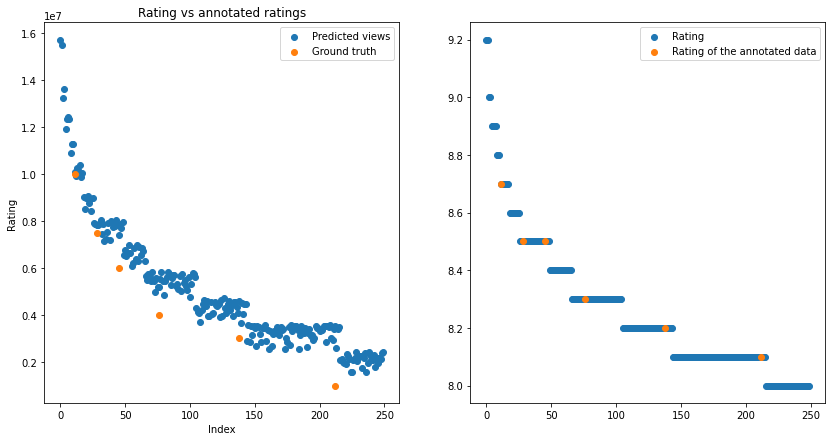

In [26]:
visualize_results(data)

Despite not being completely rigorous, this model might extend better than the ones that we have seen so far. Furthermore, it is still able to generalize the view count outside of the rule-based system.

In our quest of a simple heuristic, I would personnaly choose this one. However, its lack of mathmatical reasoning might not be pleasing for many people. I nonetheless believe that data and code is law. Without much data, complex models are rendered useless on those task and this kind of reasoning can give us a starting point to iterate upon.

## 6 - Saving the results

In [27]:
data.to_csv(OUTPUT_FILE)